In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import os

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def load_data(filename):
    # Load the dataset
    data = pd.read_csv(filename, names=['Sequence', 'Class'], delimiter=',', encoding='latin-1')
    # Convert 'Class' column to numeric, forcing non-numeric values to NaN
    data['Class'] = pd.to_numeric(data['Class'], errors='coerce')
    # Drop rows with NaN values in the 'Class' column
    data.dropna(subset=['Class'], inplace=True)
    return data

# Function to calculate molecular descriptors
def calculate_molecular_descriptors(sequence):
    # For this dataset, we'll use simple sequence-based features
    descriptors = []
    descriptors.append(len(sequence))  # Length of the sequence

    # Count of each amino acid
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    for aa in amino_acids:
        descriptors.append(sequence.count(aa))

    # Some basic physicochemical properties
    hydrophobic = 'AVILMFYW'
    polar = 'STNQ'
    positive = 'KRH'
    negative = 'DE'
    descriptors.append(sum(sequence.count(aa) for aa in hydrophobic))
    descriptors.append(sum(sequence.count(aa) for aa in polar))
    descriptors.append(sum(sequence.count(aa) for aa in positive))
    descriptors.append(sum(sequence.count(aa) for aa in negative))

    return descriptors

# Function to prepare data
def prepare_data(data):
    X = np.array([calculate_molecular_descriptors(seq) for seq in data['Sequence']])
    y = data['Class'].values

    return X, y

# Function to train and evaluate model
def train_and_evaluate_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Plot ROC and PR curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Calculate ROC curve values
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")


    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.show()

    return pipeline


Starting HIV-1 protease cleavage prediction project...
Loaded 1625 peptide sequences.
ROC AUC: 0.9689
PR AUC: 0.9313


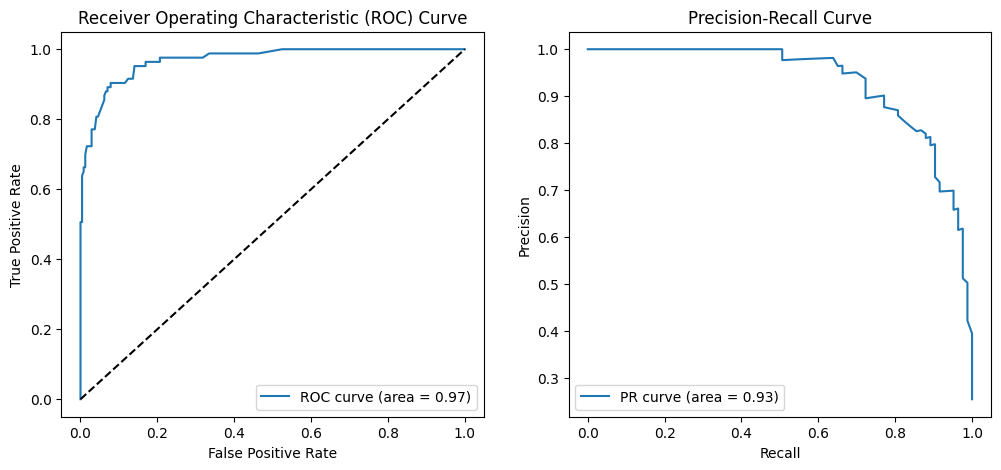


Top 10 most important features for HIV-1 protease cleavage:
        feature  importance
21  Hydrophobic    0.102377
23     Positive    0.070860
1             A    0.060277
11            M    0.056107
20            Y    0.051156
22        Polar    0.050673
18            V    0.049390
13            P    0.046488
9             K    0.044923
5             F    0.044021

Predictions for new sequences:
Sequence: SQNYPIVQ
Probability of being cleaved by HIV-1 protease: 0.5157

Sequence: ARVLAEAM
Probability of being cleaved by HIV-1 protease: 1.0000

HIV-1 protease cleavage prediction project completed.


In [ ]:
def main():
    print("Starting HIV-1 protease cleavage prediction project...")

      # Extract the zip file
    zip_path = '/content/hiv+1+protease+cleavage.zip'
    extract_to = '/content/hiv_data'
    extract_zip(zip_path, extract_to)

      # Find the data file in the extracted directory
    data_file = None
    for file in os.listdir(extract_to):
          # Modified to look for a file named '1625.data'
        if file == '1625Data.txt':
            data_file = os.path.join(extract_to, file)
            break

    if data_file is None:
        raise FileNotFoundError("Data file '1625.data' not found in the extracted zip file.")

    # Load data
    data = load_data(data_file)
    print(f"Loaded {len(data)} peptide sequences.")

    # Prepare data
    X, y = prepare_data(data)

    # Train and evaluate model
    model = train_and_evaluate_model(X, y)

    # Feature importance
    feature_importance = model.named_steps['rf'].feature_importances_
    feature_names = ['Length'] + list('ACDEFGHIKLMNPQRSTVWY') + ['Hydrophobic', 'Polar', 'Positive', 'Negative']
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTop 10 most important features for HIV-1 protease cleavage:")
    print(feature_importance_df.head(10))

    # Predict on new sequences
    new_sequences = [
        "SQNYPIVQ",
        "ARVLAEAM"
    ]
    new_X = np.array([calculate_molecular_descriptors(seq) for seq in new_sequences])
    predictions = model.predict_proba(new_X)[:, 1]

    print("\nPredictions for new sequences:")
    for seq, pred in zip(new_sequences, predictions):
        print(f"Sequence: {seq}")
        print(f"Probability of being cleaved by HIV-1 protease: {pred:.4f}")
        print()

    print("HIV-1 protease cleavage prediction project completed.")

if __name__ == "__main__":
    main()